
## Overfit for Random Forest

#### Sadam Hussain
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)

### Executive Summary

* The goal of this project is to demonstrate overfitting behavior in Random Forest regression, using corrected porosity as the target variable and TOC, Calcite, and Quartz content as predictors. We examine how model complexity and noise contribute to overfit, and show how to mitigate it through hyperparameter tuning.

* Overfitting was demonstrated by training a model on noisy data, which led to low training error but poor test performance.

* This was addressed through feature imputation (removing zero values), visualizing train/test splits, and building a mitigated model using optimized hyperparameters. A sensitivity analysis on max_depth and n_estimators further highlighted how model complexity affects overfitting. 

* Final comparisons showed that cleaning the data and tuning the model greatly improved generalization and reduced test error. 

### Import Packages
```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

### Load Data

This project uses public core analysis data from the [MSEEL Boggess 17 Pilot](http://www.mseel.org/data/Wells_Datasets/Boggess/Boggess_17Pilot/Core%20Analysis/) well.

The following workflow applies the .csv file 'CleanedUpCoreData.csv', a measured dataset for an unconventional horizontal well in a shale play in the US. 
We will work with the following features:

* **porosity** - % of rock void in units of percentage
* **TOC** - % of rock void in units of percentage occupied by organic content
* **Calcite** - % of rock mineral
* **Quartz** - % of rock mineral 

```python
my_data = pd.read_csv(r"https://raw.githubusercontent.com/Sadam7861/Clean-Core-Data/main/CleanedUpCoreData.csv") # load the comma delimited data file from Sadam7861 GitHub repository
my_data = my_data.iloc[:,2:4]                             # copy all rows and columns 2 through 4
```

### Core Analysis Modeling Workflow: Predicting Porosity with Random Forest
This workflow explores and addresses overfitting in machine learning models, specifically in Random Forest regressors, when applied to core analysis data from an unconventional well. The primary objective is to predict Corrected Porosity using geochemical features—TOC, Calcite, and Quartz—and systematically evaluate and improve model generalization. The workflow includes data preprocessing, visualization, data training/testing, analyze random forest model with and without noise, , analyze impact of model complexity on overfit and finally tuning/sensitivity of hyperparameters  to mitigate overfit. 

### 1. Load and Explore Data
The project began by loading core analysis data from a CSV file. 
In this step, the core analysis dataset was loaded, which includes geochemical features such as Total Organic Carbon (TOC), Calcite, Quartz, and the target variable Corrected Porosity — all measured in percentage (%). I begin by plotting histograms for each feature to understand their distributions, detect outliers, and identify any unusual values (such as zeros), which may introduce noise and lead to overfitting.

    Depth  CorrectedPorosity   TOC  Quartz  Calcite
0  6432.5               6.67  4.15    38.6      0.0
1  6434.5               6.07  4.25    48.6      6.2
2  6436.5               4.91  3.40    41.0      2.5
3  6438.5               6.00  0.39     4.6     66.4
4  6440.6               5.63  3.90    37.0      0.6


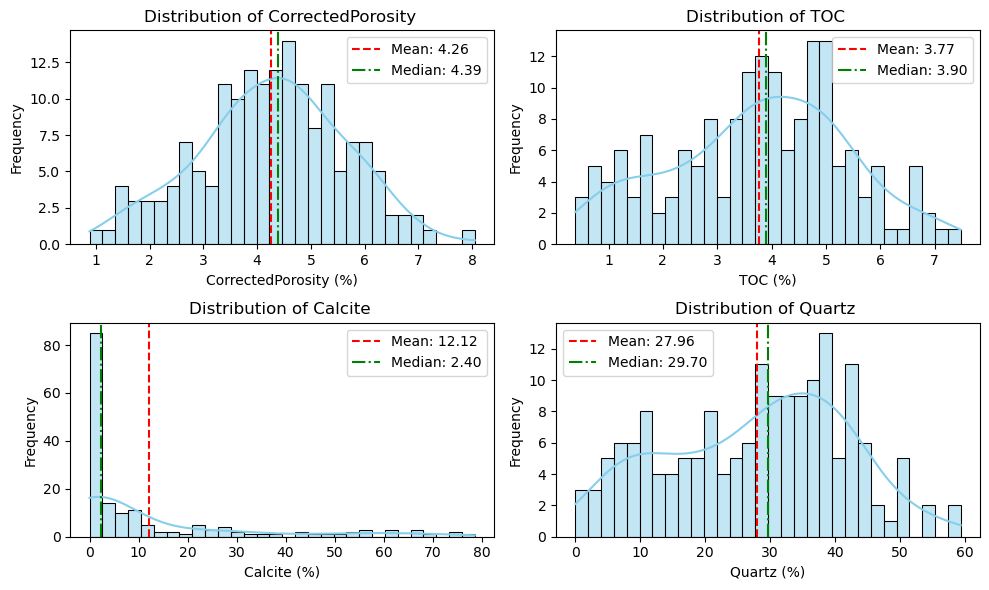

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Load the dataset
file_path = r"https://raw.githubusercontent.com/Sadam7861/Clean-Core-Data/main/CleanedUpCoreData.csv" # Update this with your file path
data = pd.read_csv(file_path)
X = data[['TOC', 'Calcite', 'Quartz']]
y = data['CorrectedPorosity']

# Display the first few rows of the dataset
print(data.head())

# Visualize histograms for all features with enhanced settings
features = ['CorrectedPorosity', 'TOC', 'Calcite', 'Quartz']
plt.figure(figsize=(10, 6))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data[feature], bins=30, kde=True, color='skyblue', edgecolor='black')

    # Calculate statistics
    mean_val = data[feature].mean()
    median_val = data[feature].median()

    # Add vertical lines for mean and median with values in legend
    plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='-.', label=f'Median: {median_val:.2f}')

    # Title and labels
    plt.title(f'Distribution of {feature} ')
    plt.xlabel(f'{feature} (%)')
    plt.ylabel('Frequency')

    # Remove minor grid lines
    plt.grid(which='minor', visible=False)

    # Legend
    plt.legend()

plt.tight_layout()
plt.show()

### 2.  Train/Test Split on Raw Data
The raw dataset is divided into training and testing subsets using an 80/20 split. Standardization is applied to normalize the input features, improving model performance and interpretability. A random seed is used during splitting to ensure unbiased and reproducible selection of samples. A scatter plot of porosity values across both sets confirms that the split captures a representative range of the data and avoids any ordering-related bias.

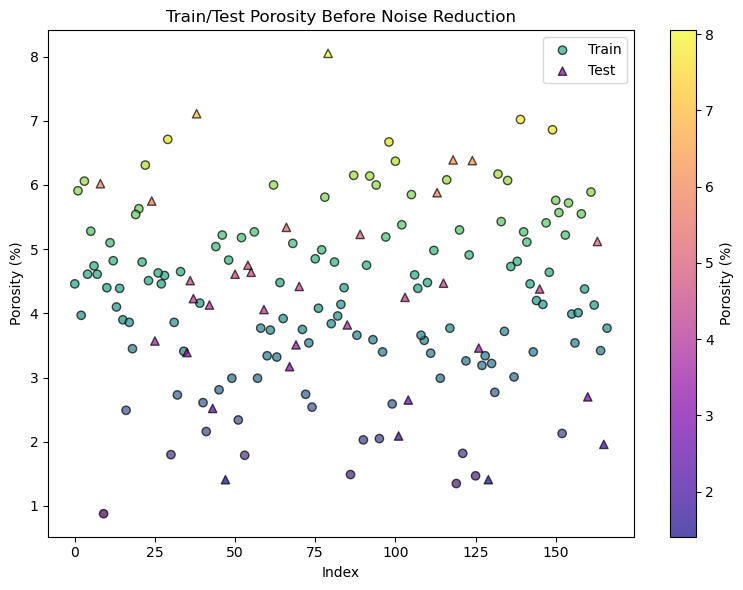

In [47]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
idx = np.random.permutation(len(y_train) + len(y_test))
train_idx = idx[:len(y_train)]
test_idx = idx[len(y_train):]
plt.figure(figsize=(8, 6))
plt.scatter(train_idx, y_train, c=y_train, cmap='viridis', label='Train', alpha=0.7, marker='o', edgecolor='k')
plt.scatter(test_idx, y_test, c=y_test, cmap='plasma', label='Test', alpha=0.7, marker='^', edgecolor='k')
plt.colorbar(label='Porosity (%)')
plt.title('Train/Test Porosity Before Noise Reduction')
plt.xlabel('Index')
plt.ylabel('Porosity (%)')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

### 3.  Overfit Model on Noisy Data
A high-capacity Random Forest model is trained on the uncleaned, noisy dataset using a large number of estimators and no restriction on tree depth. This setup is intentionally designed to overfit the training data. The model achieves a very low training error but performs poorly on the test set, demonstrating classic overfitting behavior. A scatter plot of predicted vs. actual porosity helps visualize the gap between model performance on training versus unseen data.

In [49]:
model_overfit_noisy = RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42)
model_overfit_noisy.fit(X_train, y_train)
train_pred_overfit = model_overfit_noisy.predict(X_train)
test_pred_overfit = model_overfit_noisy.predict(X_test)
mse_train_overfit = mean_squared_error(y_train, train_pred_overfit)
mse_test_overfit = mean_squared_error(y_test, test_pred_overfit)
print(f'Training MSE (Overfit): {mse_train_overfit:.3f}')
print(f'Testing MSE (Overfit): {mse_test_overfit:.3f}')

Training MSE (Overfit): 0.136
Testing MSE (Overfit): 1.337


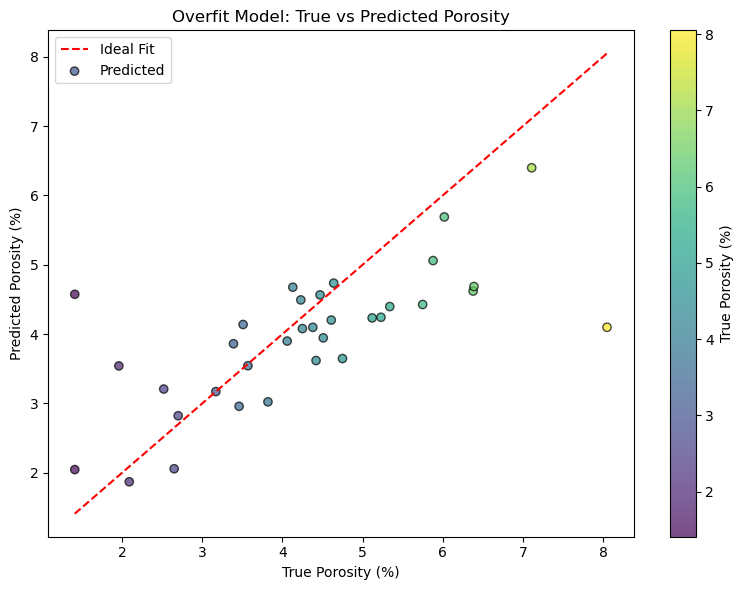

In [51]:
plt.figure(figsize=(8, 6))
ideal_line = np.linspace(y_test.min(), y_test.max(), 100)
plt.plot(ideal_line, ideal_line, '--', color='red', label='Ideal Fit')
scatter = plt.scatter(y_test, test_pred_overfit, c=y_test, cmap='viridis', alpha=0.7, edgecolor='k', label='Predicted')
plt.colorbar(label='True Porosity (%)')
plt.xlabel('True Porosity (%)')
plt.ylabel('Predicted Porosity (%)')
plt.title('Overfit Model: True vs Predicted Porosity')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

### 4.  Feature Imputation, Cleaning and Train/Test Split on Cleaned Data
To reduce noise and improve model performance, rows with zero values in critical features such as Calcite and Corrected Porosity are removed. This step serves as a basic feature imputation strategy to eliminate unrealistic or missing measurements. The cleaned dataset is then standardized and randomly split into training and testing sets using an 80/20 ratio. A scatter plot of porosity values is used to visually confirm that the random split maintains diversity and balance across both subsets.

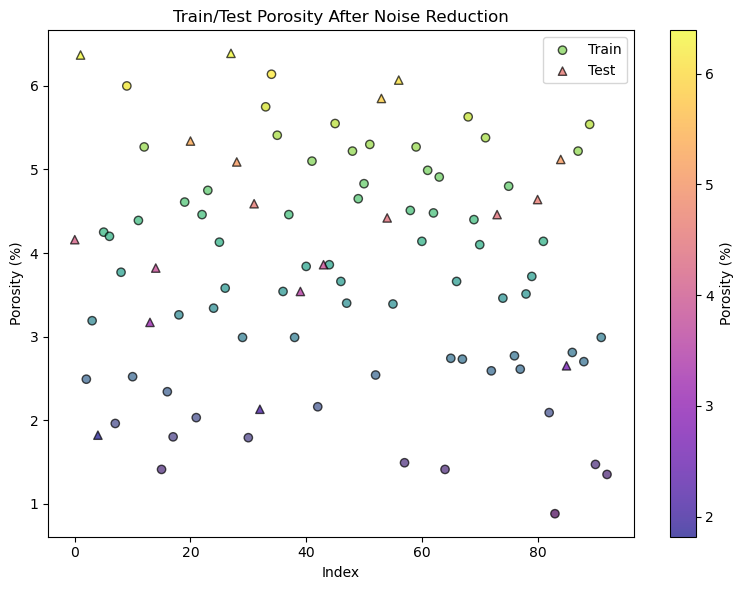

In [55]:
data_clean = data[(data['Calcite'] > 0) & (data['CorrectedPorosity'] > 0)]
X_clean = data_clean[['TOC', 'Calcite', 'Quartz']]
y_clean = data_clean['CorrectedPorosity']
scaler = StandardScaler()
X_scaled_clean = scaler.fit_transform(X_clean)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_scaled_clean, y_clean, test_size=0.2, random_state=42)
idx = np.random.permutation(len(y_train_c) + len(y_test_c))
train_idx = idx[:len(y_train_c)]
test_idx = idx[len(y_train_c):]
plt.figure(figsize=(8, 6))
plt.scatter(train_idx, y_train_c, c=y_train_c, cmap='viridis', label='Train', alpha=0.7, marker='o', edgecolor='k')
plt.scatter(test_idx, y_test_c, c=y_test_c, cmap='plasma', label='Test', alpha=0.7, marker='^', edgecolor='k')
plt.colorbar(label='Porosity (%)')
plt.title('Train/Test Porosity After Noise Reduction')
plt.xlabel('Index')
plt.ylabel('Porosity (%)')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

### 6. Improved Random Forest Model After Data Cleaning
An improved Random Forest model is developed using the cleaned dataset from the previous step. The model structure is kept similar to the overfit version but is retrained and retested on the cleaned data. This approach isolates the effect of noise reduction on model performance. A noticeable improvement is observed: the testing MSE drops from 1.337 (overfit model) to 0.865, while the training MSE remains comparable, increasing slightly from 0.136 to 0.170. This demonstrates that data cleaning alone can significantly reduce overfitting and improve generalization

Training MSE (Improved): 0.170
Testing MSE (Improved): 0.865


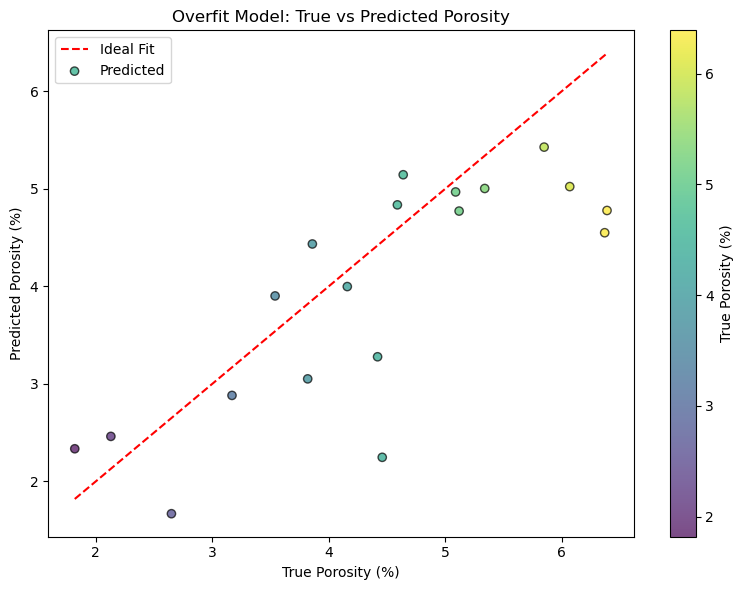

In [59]:
model_improved_noisy = RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42)
model_improved_noisy.fit(X_train_c, y_train_c)
train_pred_improved = model_improved_noisy.predict(X_train_c)
test_pred_improved = model_improved_noisy.predict(X_test_c)
mse_train_improved = mean_squared_error(y_train_c, train_pred_improved)
mse_test_improved = mean_squared_error(y_test_c, test_pred_improved)
print(f'Training MSE (Improved): {mse_train_improved:.3f}')
print(f'Testing MSE (Improved): {mse_test_improved:.3f}')

plt.figure(figsize=(8, 6))
ideal_line = np.linspace(y_test_c.min(), y_test_c.max(), 100)
plt.plot(ideal_line, ideal_line, '--', color='red', label='Ideal Fit')
scatter = plt.scatter(y_test_c, test_pred_improved, c=y_test_c, cmap='viridis', alpha=0.7, edgecolor='k', label='Predicted')
plt.colorbar(label='True Porosity (%)')
plt.xlabel('True Porosity (%)')
plt.ylabel('Predicted Porosity (%)')
plt.title('Overfit Model: True vs Predicted Porosity')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

### 7.  Mitigated Model with Tuned Hyperparameters
A Random Forest model is retrained on the cleaned dataset using optimized hyperparameters to mitigate overfitting and improve generalization. The selected parameters are:

n_estimators = 150
max_depth = 7
min_samples_split = 5
min_samples_leaf = 4
random_state = 42

This configuration reduces model complexity while maintaining predictive strength. Compared to previous models, the mitigated model achieves improved generalization with Training MSE = 0.605 and Testing MSE = 0.839. These results indicate that a well-tuned Random Forest model, combined with noise reduction, can effectively address overfitting in core analysis datasets.

Training MSE (Mitigated): 0.605
Testing MSE (Mitigated): 0.839


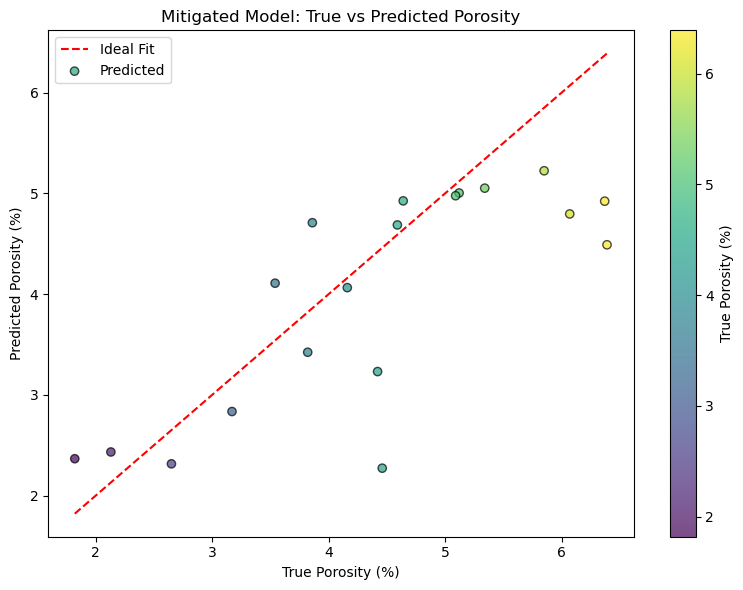

In [62]:
model_mitigated = RandomForestRegressor(
    n_estimators=150,
    max_depth=7,
    min_samples_leaf=4,
    min_samples_split=5,
    random_state=42
)
model_mitigated.fit(X_train_c, y_train_c)
train_pred_mitigated = model_mitigated.predict(X_train_c)
test_pred_mitigated = model_mitigated.predict(X_test_c)
mse_train_mitigated = mean_squared_error(y_train_c, train_pred_mitigated)
mse_test_mitigated = mean_squared_error(y_test_c, test_pred_mitigated)
print(f'Training MSE (Mitigated): {mse_train_mitigated:.3f}')
print(f'Testing MSE (Mitigated): {mse_test_mitigated:.3f}')

plt.figure(figsize=(8, 6))
ideal_line = np.linspace(y_test_c.min(), y_test_c.max(), 100)
plt.plot(ideal_line, ideal_line, '--', color='red', label='Ideal Fit')
scatter = plt.scatter(y_test_c, test_pred_mitigated, c=y_test_c, cmap='viridis', alpha=0.7, edgecolor='k', label='Predicted')
plt.colorbar(label='True Porosity (%)')
plt.xlabel('True Porosity (%)')
plt.ylabel('Predicted Porosity (%)')
plt.title('Mitigated Model: True vs Predicted Porosity')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

### 8.  Sensitivity to Model Complexity
A sensitivity analysis is performed to evaluate the impact of model complexity on overfitting by varying two key hyperparameters:

max_depth: tested over the range [3, 5, 7, 9]

n_estimators: tested over the range [10, 20, 40, 60, 80, 100]

Each configuration is evaluated using the cleaned dataset and consistent train/test split. The analysis shows that as max_depth and n_estimators increase, the model may overfit if complexity is not properly constrained. The resulting plots help identify the optimal balance where test MSE is minimized without excessive training performance gains, reinforcing the importance of tuning model size to the available data quality and quantity.

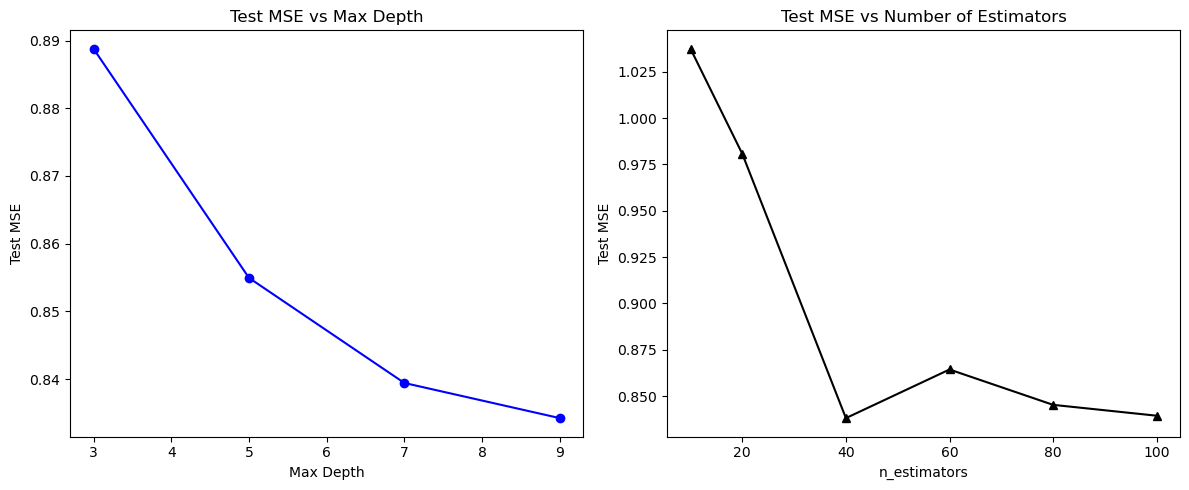

In [69]:
depths = [3, 5, 7, 9]
n_estimators = [10, 20, 40, 60, 80, 100]
depth_errors = []
estimator_errors = []

for d in depths:
    model = RandomForestRegressor(n_estimators=100, max_depth=d, random_state=42)
    model.fit(X_train_c, y_train_c)
    depth_errors.append(mean_squared_error(y_test_c, model.predict(X_test_c)))

for n in n_estimators:
    model = RandomForestRegressor(n_estimators=n, max_depth=7, random_state=42)
    model.fit(X_train_c, y_train_c)
    estimator_errors.append(mean_squared_error(y_test_c, model.predict(X_test_c)))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(depths, depth_errors, marker='o', color='blue')
plt.title('Test MSE vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Test MSE')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.plot(n_estimators, estimator_errors, marker='^', color='black' )
plt.title('Test MSE vs Number of Estimators')
plt.xlabel('n_estimators')
plt.ylabel('Test MSE')
plt.grid(False)
plt.tight_layout()
plt.show()

### ✅ Comparison: Original vs Improved and Mitigated Random Forest Models

### 🔧 Hyperparameter Differences

| Parameter           | Overfit Model              | Improved Model (Noise Reduction Only) | Mitigated Model (Tuned)        |
|---------------------|----------------------------|----------------------------------------|--------------------------------|
| `n_estimators`      | 300                        | 200                                    | 150                            |
| `max_depth`         | None (no limit)            | 8                                      | 7                              |
| `min_samples_split` | Default (2)                | Default (2)                             | 5                              |
| `min_samples_leaf`  | Default (1)                | Default (1)                             | 4                              |
| `bootstrap`         | True                       | True                                    | True                           |

---

#### 📉 Model Performance
| Metric              | Overfit Model | Improved Model (Noise Reduction Only) | Mitigated Model |
|---------------------|---------------|----------------------------------------|------------------|
| **Training MSE**    | 0.136         | 0.170                                  | 0.605            |
| **Testing MSE**     | 1.337         | 0.865                                  | 0.839            |
- he improved model based on noise reduction already shows significant reduction in overfitting, with further improvement achieved by tuning model complexity in the mitigated version.
- Lower risk of overfitting compared to the original mitigated model.

### 📊 Visualization & Diagnostic Enhancements

- ✅ Scatter plots with **colormaps** representing true porosity values  
- ✅ Ideal fit line in all prediction plots for easy visual reference  
- ✅ Train/test split visualizations to verify randomness and diversity  
- ✅ Histograms with annotated **mean** and **median** statistics  
- ✅ Sensitivity plots for `max_depth` and `n_estimators` showing complexity trade-offs

#### 🧠 Key Takeaway:
Overfitting in Random Forest models can be significantly reduced by addressing data quality issues and tuning model complexity. The noise-reduced model demonstrates clear improvement, while the fully mitigated version balances accuracy and generalization. Together, these steps establish a robust and interpretable workflow for porosity prediction in geoscientific datasets.


### Results

## 📌 Conclusion and Results

This project explored overfitting in Random Forest regression using a core analysis dataset, with Corrected Porosity as the target variable and TOC, Calcite, and Quartz as predictors. Three models were evaluated to demonstrate the impact of data noise and model complexity on performance:

- 🔴 **Overfit Model**: Trained on noisy data with no limits on complexity.
- 🟡 **Improved Model (Cleaned)**: Trained on cleaned data (zero values removed) but with default model settings.
- 🟢 **Mitigated Model (Tuned)**: Trained on cleaned data using tuned hyperparameters to reduce complexity.

### 📊 Performance Summary

| Model               | Training MSE | Testing MSE | Overfitting Indicator (Test - Train) |
|---------------------|--------------|-------------|--------------------------------------|
| Overfit             | 0.136        | 1.337       | 1.201                                |
| Improved (Cleaned)  | 0.170        | 0.865       | 0.695                                |
| Mitigated (Tuned)   | 0.605        | 0.839       | 0.234                                |

### 🔍 Key Findings

- 🔴 **Overfit Model**:
  - Achieved very low training error, but extremely high test error.
  - The large overfitting gap (**1.201**) indicates the model memorized training data rather than learning general patterns.
  - Used `n_estimators=300` and `max_depth=None` (unconstrained trees), leading to excessive complexity.

- 🟡 **Improved Model (Noise Reduction)**:
  - After removing rows with zero values in `Calcite` and `Porosity`, test error dropped significantly from **1.337 → 0.865**.
  - Overfitting was reduced by ~40%, proving that data quality strongly impacts generalization.
  - Model used default hyperparameters, so improvements came solely from cleaning.

- 🟢 **Mitigated Model (Tuned)**:
  - Further reduced overfitting with tuned parameters:
    - `n_estimators=150`, `max_depth=7`, `min_samples_split=5`, `min_samples_leaf=4`
  - Achieved the smallest overfitting gap (**0.234**) while keeping test MSE low (**0.839**).
  - This model balances generalization and simplicity, making it more interpretable and robust.

### 🙋‍♂️ Parting Comments
This project demonstrates a complete machine learning workflow applied to real-world core analysis data, highlighting how data quality and model tuning impact predictive accuracy in subsurface reservoir modeling. I’m passionate about integrating data science with energy and geoscience challenges and am actively seeking internship or full-time opportunities in petroleum engineering, machine learning, or subsurface data analytics. I would be excited to collaborate or connect with professionals and researchers in these fields.